### 0. Utilities

#### Imports

In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from utils.constants import STANDARDS
from utils.types import IndustryStandard
from utils.functions.files import read_inference, read_correspondence
from utils.functions.similarity import similarity_score

#### Constants

In [3]:
# Standard code difference threshold, 't'
DIFF_THRESHOLD = 5

inference_dfs = read_inference()

#### Helper functions

##### Obtaining column names

In [4]:
# Obtain concise column name, given ICS and company role
new_col = lambda std: f"{std.value} code"

# Obtain column name for similarity score, given ICS and company role
similarity_col = lambda std: f"{std.value} code sim. score"

### 1. Reading the MAESTRI dataset

#### Importing the spreadsheet

In [5]:
correspondence_dfs = read_correspondence()

In [6]:
correspondence_dfs[IndustryStandard.NACE].head()

,ISIC code,SSIC code,WZ code
Code,,,
0111,0111,01119,0111
0112,0112,01119,0112
0113,0113,01111;01112;01113;01120,0113
0114,0114,01190,0114
0115,0115,01190,0115


### 2. Obtaining similarity scores for validation

In [7]:
# Loop through all standards
for std in STANDARDS:
    df = correspondence_dfs[std].copy()
    
    stds = [IndustryStandard[col.replace(" code", "")] for col in df.columns]
    
    # Iterate through all standards except NACE as it is to be compared with
    for s in stds:
        if s != std:
            # Zip the NACE and standard columns to iterate through
            tuples = zip(df.index, [std] * df.shape[0], df[new_col(s)], [s] * df.shape[0])
            
            # Append the similarity score column of a certain standard to the DataFrame for a given role
            df[similarity_col(s)] = [similarity_score(*a) for a in tuples]
            
            df[df[similarity_col(s)] == ""] = ""
            
            # Convert the similarity score column data type to 'float'
            df[similarity_col(s)] = df[similarity_col(s)].astype(float)
    
    # List containing new order of columns for readability
    cols = [f(s) for s in stds if s != std for f in (new_col, similarity_col)]
    
    # Reorder columns for readability
    correspondence_dfs[std] = df[cols]

In [8]:
correspondence_dfs[IndustryStandard.NACE].head()

,ISIC code,ISIC code sim. score,SSIC code,SSIC code sim. score,WZ code,WZ code sim. score
Code,,,,,,
0111,0111,1.0,01119,1.0,0111,1.0
0112,0112,1.0,01119,1.0,0112,1.0
0113,0113,1.0,01111;01112;01113;01120,1.0,0113,1.0
0114,0114,1.0,01190,1.0,0114,1.0
0115,0115,1.0,01190,1.0,0115,1.0


### 3. Model performance statistics

In [9]:
# Score ategories
score_categories = ["s = 0", "0 < s < 1", "s = 1"]

# Determine counts for a given series
get_counts = lambda f: lambda x: {
    "s = 0": [len(arr[(arr == 0)]) for arr in f(x)],
    "0 < s < 1": [len(arr[(arr > 0) & (arr < 1)]) for arr in f(x)],
    "s = 1": [len(arr[arr == 1]) for arr in f(x)]
}

# Determine percents for a given series
get_percents = lambda f: lambda x: {
    "s = 0": [len(arr[arr == 0]) / len(arr) for arr in f(x)],
    "0 < s < 1": [len(arr[(arr > 0) & (arr < 1)]) / len(arr) for arr in f(x)],
    "s = 1": [len(arr[arr == 1]) / len(arr) for arr in f(x)]
}

#### By industry classification standard

In [10]:
# Function to extract all scores by role
scores = lambda std: [np.array(correspondence_dfs[std][col]) for col in correspondence_dfs[std].columns if " code sim. score" in col]

# Function to calculate score count breakdown (by role)
scores_counts = get_counts(scores)

# Function to calculate score percentage (by role) breakdown
scores_percents = get_percents(scores)

#### Visualising similarity scores

In [11]:
# Bar width for every plot
bar_width = 0.3

##### By industry classification standard

In [12]:
# Create a subplot based on a given ICS
def score_subplot(std, ax, is_percent=False):
    # Obtain the dictionary with the breakdown of values by similarity score
    values_dict = scores_percents(std) if is_percent else scores_counts(std)
    
    df = correspondence_dfs[std].copy()
    x = [IndustryStandard[col.replace(" code sim. score", "")].value for col in df.columns if " code sim. score" in col]
    
    # Initial bar heights
    bottom = np.zeros(len(values_dict))
    
    print(x)
    print(values_dict)
    
    i = 0
    
    # Looping through each category ('s = 0', '0 < s < 1', 's = 1')
    for category, y in values_dict.items():
        if i < 1:
            # Add bars for each category for all roles ('Donor', 'Intermediary', 'Receiver')
            ax.bar(x, y, bar_width, label=category, bottom=bottom)
            
            # Increment the base bar heights
            bottom += y
            
            i += 1
        
        break
    
    # Set the title of the subplot
    ax.set_title(std.value)
    
    # Rotate the x-ticks by 45 degrees
    ax.tick_params(axis="x", labelrotation=45)
    
    # If the type of plot is a percentage plot,
    if is_percent:
        # format the y-axis to be percentage values
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

['ISIC', 'WZ']
{'s = 0': [14, 16], '0 < s < 1': [81, 81], 's = 1': [932, 930]}


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 3 with shape (3,).

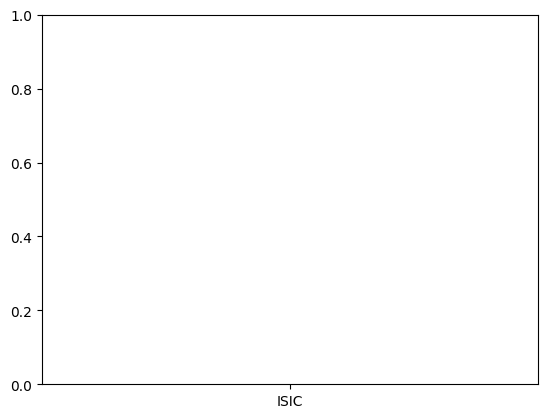

In [13]:
fig, axs = plt.subplots(ncols=1)

# Add subplots for each standard
# for std, ax in zip(STANDARDS, axs):
#     score_subplot(std, ax)
score_subplot(IndustryStandard.SSIC, axs)

# Add a legend to the figure
# handles, labels = plt.gca().get_legend_handles_labels()
# fig.legend(handles, labels, ncol=len(roles), loc="lower center", bbox_to_anchor=[0.5, -0.05])

# Set the title of the figure
fig.suptitle(f"Correspondence table threshold score distribution (t = {DIFF_THRESHOLD})")

# Add enough padding between subplots to prevent overlapping
fig.tight_layout()

plt.show()

### 4. Exporting results to Excel

In [ ]:
# with pd.ExcelWriter(f"{EXPORTS_PATH}/Exchanges-database Maestri_accuracy.xlsx") as writer:
#     for i in range(len(test_dfs)):
#         role = roles[i]
#         df = test_dfs[i]
        
#         df.to_excel(writer, sheet_name=role, index=False)
#         worksheet = writer.sheets[role]
#         workbook = writer.book
        
#         format = workbook.add_format()
#         format.set_align('left')
#         format.set_align('vcenter')
        
#         # Loop through all columns
#         for index, col in enumerate(df):
#             series = df[col]
#             max_len = max((
#                 series.astype(str).map(len).max(),  # Length of largest item
#                 len(str(series.name))               # Length of column name/header
#             ))
            
#             # Set column width
#             worksheet.set_column(index, index, max_len, format)

NACE - 2410 - Manufacture of basic iron and steel and of ferro-alloys

WZ   - 2452 - Casting of steel